In [24]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

# Hands-on Activity 22.3: Tuning the Hyperparameters

## Objectives

+ Tune the hyper-parameters of a Gaussian process using maximum marginal likelihood.

## References

+ [Chapter 5 of GP for ML textbook](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf).

## Example: Gaussian process regression with fitted hyperparameters

Let's generate synthetic data:

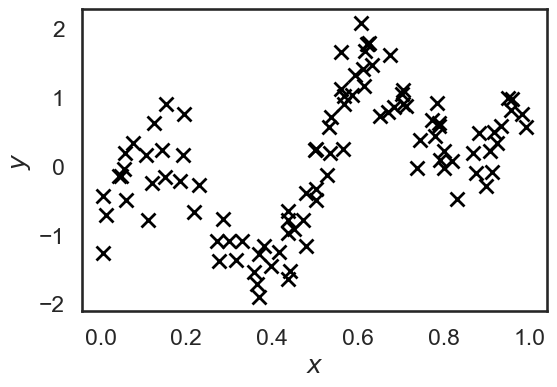

In [25]:
# Fixing the seed so that we all see the same data
np.random.seed(1234)
n = 100
# The inputs are in [0, 1]
X = np.random.rand(n, 1) # Needs to be an n x 1 vector
# The outputs are given from a function plus some noise
# The standard deviation of the noise is:
sigma = 0.4
# The true function that we will try to identify
f_true = lambda x: -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
# Some data to train on
Y = f_true(X) + sigma * np.random.randn(X.shape[0], 1)
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

Let's pick a squared exponential kernel and make a model with Gaussian likelihood (the default choice):

In [26]:
import GPy
k = GPy.kern.RBF(1)
gpm = GPy.models.GPRegression(X, Y, k)
print(gpm)


Name : GP regression
Objective : 130.6350923033061
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Let's explain what all this means.
Notice that there are some default values for the hyperparameters (they are all one).
Also, notice that ``GPy`` is keeping track of how many parameters it needs to fit.
Here we have three parameters ($s,\ell$ and $\sigma$).
The second column are constraints for the parameters.
The ``+ve`` term means that the corresponding hyperparamer has to be positive.
Notice that there is nothing in the ``priors`` column.
This is because we have set no priors right now.
When this happens, ``GPy`` assumes that we assign a flat prior, i.e., here it assumes that we have assigned $p(\theta)\propto 1$ and $p(\sigma)\propto 1$.
That's not the best choice, but it should be ok for now.

Now, pay attention to the ``Objective``. This is the $-\log p(\theta,\sigma|\mathcal{D})$ for the current choice of parameters.
Let's now find the MAP:

In [27]:
gpm.optimize(messages=True)
print(gpm)


Name : GP regression
Objective : 59.75028295702219
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.9746223001522172  |      +ve      |        
  rbf.lengthscale          |  0.12867286974470898  |      +ve      |        
  Gaussian_noise.variance  |  0.13869903537692438  |      +ve      |        


Ok. We did find something with higher posterior value.
Let's plot the prediction:

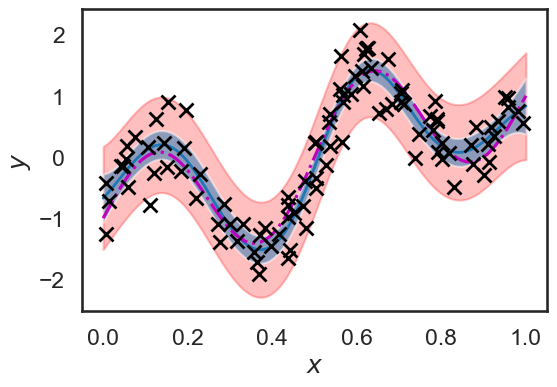

In [28]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
x_star = np.linspace(0, 1, 100)[:, None]
m_star, v_star = gpm.predict(x_star)
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');

Admitidly, this doesn't look very good.
(Of course, we can tell this only because we know the truth).
It seems that the assigned lengthscale is too small.
Also, the likelihood variance seems smaller than it really is.
What do we do now?
You have two choices:
+ You encode some prior knowledge and repeat.
+ You add some more data and repeat.

Let's start with some prior knowledge and let the other item for the questions section.
Let's say that we know that the noise variance.
How do we encode this?
Here you go:

In [29]:
gpm.likelihood.variance.constrain_fixed(sigma ** 2)
print(gpm)


Name : GP regression
Objective : 60.19042706023323
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.9746223001522172  |      +ve      |        
  rbf.lengthscale          |  0.12867286974470898  |      +ve      |        
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |        


Notice that it now ``GPy`` reports that the likelihood variance is fixed.
Let's repeat the optimization:

In [30]:
gpm.optimize(messages=True)
print(gpm)


Name : GP regression
Objective : 60.18800108790963
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   1.0087153732926477  |      +ve      |        
  rbf.lengthscale          |    0.131442394540441  |      +ve      |        
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |        


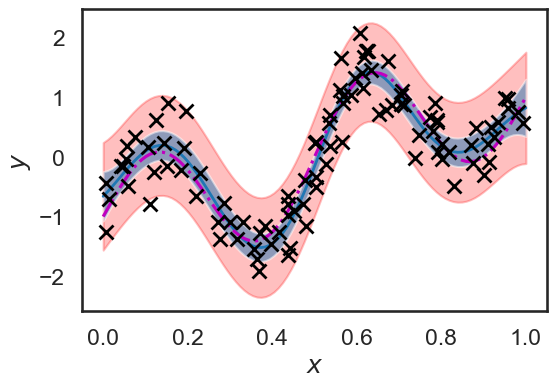

In [31]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
m_star, v_star = gpm.predict(x_star)
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');

This looks better.
But it seems that the automatically selected lengthscale is smaller than the true one.
(Of course, in reality, we don't really know what the true lengthscale is).
Let's assign a prior probability density on the lengthscale which pushes it to be greater.
Since we are dealing with a positie parameter and we don't know much about it, let's assign an exponential prior with a rate of 2 (which will yield an expectation of 0.5):
$$
\ell \sim \operatorname{Log-N}(0.2, 1).
$$

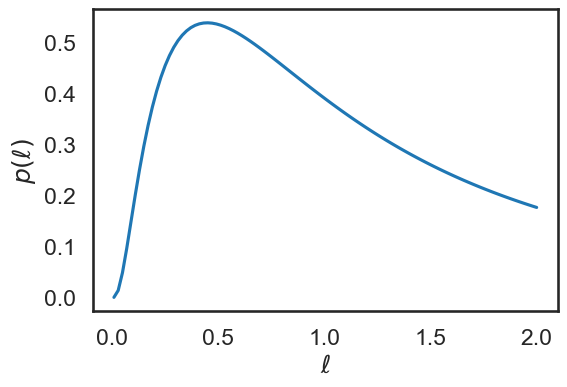

In [32]:
ell_prior = GPy.priors.LogGaussian(.2, 1.0)
# Let's visualize it to make sure it's ok
fig, ax = plt.subplots(dpi=100)
ells = np.linspace(0.01, 2.0, 100)
ax.plot(ells, ell_prior.pdf(ells))
ax.set_xlabel('$\ell$')
ax.set_ylabel('$p(\ell)$');

Now here is how you can set it:

In [33]:
gpm.kern.lengthscale.set_prior(ell_prior)
print(gpm)

reconstraining parameters GP_regression.rbf.lengthscale



Name : GP regression
Objective : 63.65657746403857
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |    priors   
  rbf.variance             |   1.0087153732926477  |      +ve      |             
  rbf.lengthscale          |    0.131442394540441  |      +ve      |  lnN(0.2, 1)
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |             


In [34]:
gpm.optimize(messages=True)
print(gpm)


Name : GP regression
Objective : 63.50112557033768
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |    priors   
  rbf.variance             |   1.4173684868988239  |      +ve      |             
  rbf.lengthscale          |    0.149518870507074  |      +ve      |  lnN(0.2, 1)
  Gaussian_noise.variance  |  0.16000000000000003  |   +ve fixed   |             


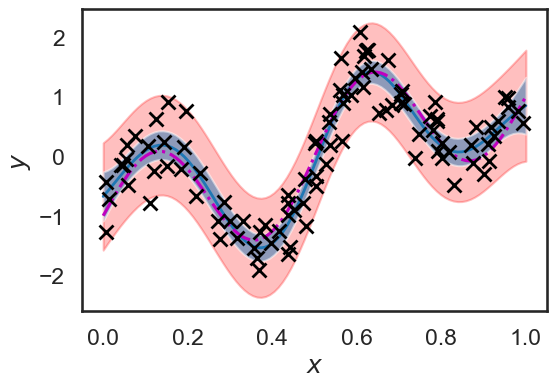

In [35]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
m_star, v_star = gpm.predict(x_star)
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');

That's better, but not perfect.
But remember: You don't know what the truth is...

## Questions

Let's investigate what happens to the previous examples as you increase the number of observations.

+ Rerun everything gradually increasing the number of samples from $n=10$ to $n=100$.
Notice that as the number of samples increases it doesn't really matter what your prior knowledge is.
As a matter of fact, for the largest number of samples you try, pick a very wrong prior probability for $\ell$.
See what happens.

+ Rerun everything with $\sigma=0.01$ (small noise) and gradually increasing the number of samples from $n=10$ to $n=100$.
For small noise, the model is trying to interpolate.
Is it capable of figuring out that the noise is small when the number of observations is limited? When does the method realize the noise is indeed small?